In [2]:
import os
import zipfile
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

# Model traning, image processing
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [4]:
# Extracting images from the zip file

def extract_and_split(zip_path, output_dir, split_ratio=0.8):
    """
    Extracts a zip file, merges class folders from training and testing, and performs a stratified train-test split.

    Parameters:
        zip_path (str): Path to the archive.zip file.
        output_dir (str): Path to the output directory where the train-test split will be stored.
        split_ratio (float): Proportion of data to use for training (default is 0.8).
    """
    # Temporary extraction path
    temp_dir = os.path.join(output_dir, "temp")

    # Ensure output and temp directories exist
    os.makedirs(temp_dir, exist_ok=True)
    os.makedirs(output_dir, exist_ok=True)

    # Extract zip file
    print("Extracting zip file...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

    # Paths to class folders inside the training and testing directories
    class_folders = ['glioma', 'meningioma', 'notumor', 'pituitary']
    dataset_folder = os.path.join(output_dir, "dataset")
    os.makedirs(dataset_folder, exist_ok=True)

    # Merge all class folders from training and testing
    print("Merging training and testing folders...")
    for class_name in class_folders:
        class_dir = os.path.join(dataset_folder, class_name)
        os.makedirs(class_dir, exist_ok=True)
        for base_folder in ['Training', 'Testing']:
            base_path = os.path.join(temp_dir, base_folder, class_name)
            if os.path.exists(base_path):
                for file_name in os.listdir(base_path):
                    src_file = os.path.join(base_path, file_name)
                    dest_file = os.path.join(class_dir, file_name)
                    if os.path.isfile(src_file):
                        shutil.copy(src_file, dest_file)

    # Create train-test split directories
    train_folder = os.path.join(output_dir, "train")
    test_folder = os.path.join(output_dir, "test")
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Perform stratified splitting for each class
    print("Performing stratified train-test split...")
    for class_name in class_folders:
        class_dir = os.path.join(dataset_folder, class_name)
        all_files = os.listdir(class_dir)

        # Stratified train-test split
        train_files, test_files = train_test_split(
            all_files, train_size=split_ratio, random_state=42
        )

        # Copy files to train/test directories for the respective class
        class_train_dir = os.path.join(train_folder, class_name)
        class_test_dir = os.path.join(test_folder, class_name)
        os.makedirs(class_train_dir, exist_ok=True)
        os.makedirs(class_test_dir, exist_ok=True)

        for file_name in train_files:
            shutil.copy(os.path.join(class_dir, file_name), class_train_dir)
        for file_name in test_files:
            shutil.copy(os.path.join(class_dir, file_name), class_test_dir)

    # Clean up temporary files
    print("Cleaning up temporary files...")
    shutil.rmtree(temp_dir)

    print("Train-test split completed.")


In [5]:
# Example usage
zip_path = "/content/archive.zip"  # Path to your zip file
output_dir = "data"    # Path to the output directory

extract_and_split(zip_path, output_dir)
# if you get a zip file error, it hasn't finished uploading. Wait a few minutes

Extracting zip file...
Merging training and testing folders...
Performing stratified train-test split...
Cleaning up temporary files...
Train-test split completed.


In [28]:
data_dir = "./data/train"
batch_size = 32
img_size = (120, 120)

In [29]:
#load dataset
train_ds, val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="both",
    seed=2045,
    image_size=img_size,
    batch_size=batch_size
)


Found 5617 files belonging to 4 classes.
Using 4494 files for training.
Using 1123 files for validation.


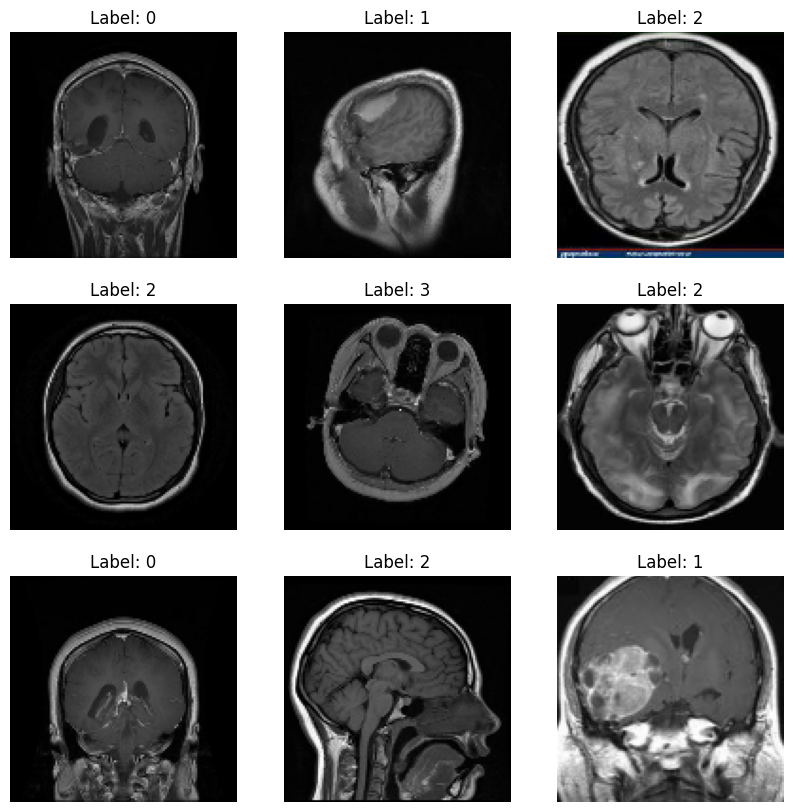

In [32]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show the first 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()
    break


In [33]:
# Optional: Cache datasets for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [34]:
# Normalize images (scale pixel values to [0,1])
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [35]:
# Creating one hot incoding for the labels
def preprocess_to_one_hot(features, labels):
    # One-hot encode the labels
    labels = tf.one_hot(tf.cast(labels, tf.int32), depth=4)  # 4 = num_classes
    return features, labels

# Apply preprocessing to the train and validation datasets
train_ds = train_ds.map(preprocess_to_one_hot)
val_ds = val_ds.map(preprocess_to_one_hot)


In [36]:
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [37]:
#Creating the model architecture
num_classes = 4
img_rows, img_cols = img_size


model = Sequential([
    Input(shape=(img_rows, img_cols, 3)),  # Input for color images
    # Convolutional Layer 1
    Conv2D(4, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Convolutional Layer 2
    Conv2D(8, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Convolutional Layer 3
    Conv2D(16, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Global Average Pooling (replaces Flatten)
    GlobalAveragePooling2D(),

    # Fully Connected Layers
    Dense(32, activation='relu'),  # Reduce units to manage parameters
    Dropout(0.4),
    Dense(num_classes, activation='softmax')  # Output layer
])


In [38]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 118, 118, 4)         │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 118, 118, 4)         │              16 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 59, 59, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 59, 59, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 57, 57, 8)           │             296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 57, 57, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 28, 28, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 26, 26, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 26, 26, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 13, 13, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 13, 13, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 16)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,364 (9.23 KB)

 Trainable params: 2,308 (9.02 KB)

 Non-trainable params: 56 (224.00 B)

In [17]:
sub_train = train_ds.take(500)
sub_val = val_ds.take(100)

In [39]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    verbose=1
)

Epoch 1/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 61s 324ms/step - accuracy: 0.3753 - loss: 1.2884 - val_accuracy: 0.2734 - val_loss: 1.4311
Epoch 2/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 302ms/step - accuracy: 0.6035 - loss: 0.9826 - val_accuracy: 0.2858 - val_loss: 1.3021
Epoch 3/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 46s 324ms/step - accuracy: 0.6807 - loss: 0.8311 - val_accuracy: 0.3936 - val_loss: 1.1218
Epoch 4/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 302ms/step - accuracy: 0.7041 - loss: 0.7779 - val_accuracy: 0.5476 - val_loss: 1.0366
Epoch 5/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 83s 307ms/step - accuracy: 0.7120 - loss: 0.7409 - val_accuracy: 0.6118 - val_loss: 0.8741
Epoch 6/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 81s 303ms/step - accuracy: 0.7202 - loss: 0.7347 - val_accuracy: 0.6180 - val_loss: 0.8454
Epoch 7/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 84s 322ms/step - accuracy: 0.7404 - loss: 0.7006 - val_accuracy: 0.6483 - val_loss: 0.7780
Epoch 8/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 304ms/step - accuracy: 0.7521 - loss: 0

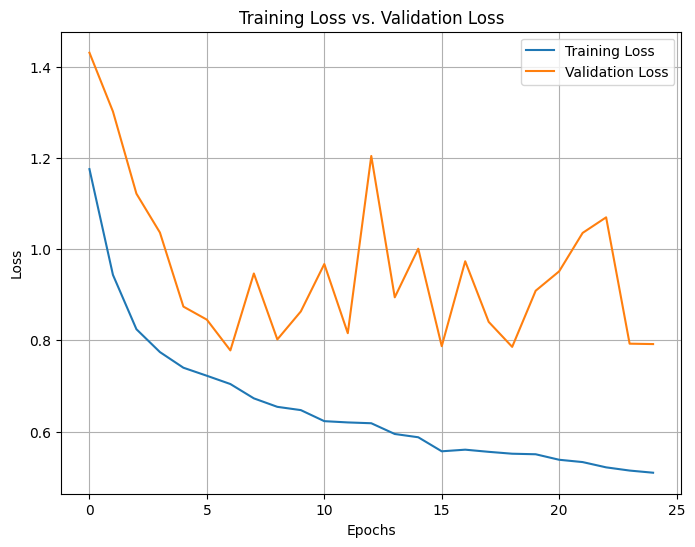

In [75]:
# Extract loss values from history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the losses
plt.figure(figsize=(8, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [79]:
test_ds = image_dataset_from_directory(
    "data/test",               # Path to the test directory
    image_size=img_size,       # Target size for resizing images (e.g., (192, 192))
    batch_size=batch_size,     # Batch size
    shuffle=False              # Do not shuffle for consistent predictions
)
not_normalized_test_ds = test_ds

Found 1406 files belonging to 4 classes.


In [80]:
test_ds.class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

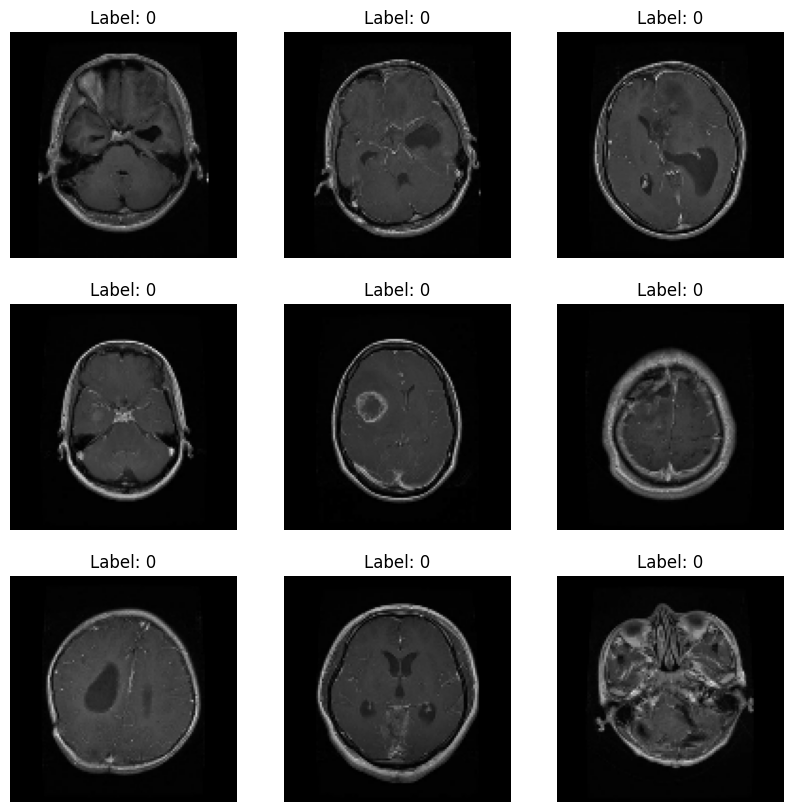

In [81]:
for images, labels in not_normalized_test_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show the first 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()
    break

In [82]:
#Normalizing the images in test dataset
normalization_layer = tf.keras.layers.Rescaling(1./255)

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


In [83]:
#Creating one hot incoding for the labels
test_ds = test_ds.map(preprocess_to_one_hot)

In [84]:
#Checking the shape of the test_ds
for images, labels in test_ds.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    print(f"Class labels: {labels.numpy()}")


Image batch shape: (32, 120, 120, 3)
Label batch shape: (32, 4)
Class labels: [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [85]:
results = model.evaluate(test_ds)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.6860 - loss: 0.8543
Test Loss: 0.8108291029930115
Test Accuracy: 0.6984353065490723


In [86]:
predictions = model.predict(test_ds)

# Display predictions for the first batch
for i, pred in enumerate(predictions[:5]):
    print(f"Image {i}: Predicted class = {tf.argmax(pred).numpy()}, Probabilities = {pred}")


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step
Image 0: Predicted class = 0, Probabilities = [0.9701149  0.01523557 0.00634416 0.00830541]
Image 1: Predicted class = 0, Probabilities = [0.97359383 0.00551439 0.01659814 0.00429359]
Image 2: Predicted class = 0, Probabilities = [0.9481841  0.00473532 0.04361246 0.00346801]
Image 3: Predicted class = 0, Probabilities = [9.9603695e-01 2.9883017e-03 8.0838724e-04 1.6632347e-04]
Image 4: Predicted class = 0, Probabilities = [9.7919273e-01 5.1768619e-04 2.0239739e-02 4.9864204e-05]


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step


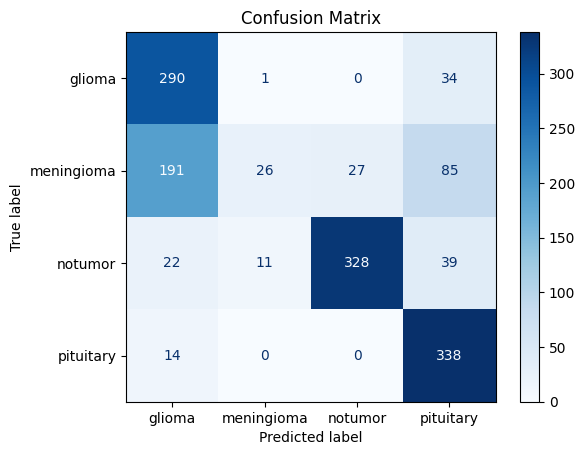

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Get ground truth labels
true_labels = []
for _, labels in test_ds:
    true_labels.extend(labels.numpy())

# Convert true_labels from one-hot encoding to class indices if necessary
true_labels = np.argmax(true_labels, axis=1) if len(np.array(true_labels).shape) > 1 else np.array(true_labels)

# Step 2: Get predicted labels
predictions = model.predict(test_ds)  # Get all predictions at once
predicted_labels = np.argmax(predictions, axis=1)

# Step 3: Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Step 4: Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['glioma', 'meningioma', 'notumor', 'pituitary'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [98]:
# Step 1: Make predictions on the test dataset
true_labels = []
images = []
for img_batch, label_batch in not_normalized_test_ds:
    true_labels.extend(label_batch.numpy())
    images.extend(img_batch.numpy())


In [115]:
#predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Step 2: Identify misclassified images
true_labels = np.array(true_labels)
meningioma_misclassified_glioma_indices = np.where((true_labels == 1) & (predicted_labels == 0))[0]  # True: meningioma (1), Predicted: glioma (0)
meningioma_correct_indices = np.where((true_labels == 1) & (predicted_labels == 1))[0]   # True: meningioma (1), Predicted: meningioma (1)
glioma_correct_indices = np.where((true_labels == 0) & (predicted_labels == 0))[0]  # True: glioma (0), Predicted: glioma (0)
pituitary_correct_indices = np.where((true_labels == 3) & (predicted_labels == 3))[0]  # True: pituitary (3), Predicted: pituitary (3)
notumor_correct_indices = np.where((true_labels == 2) & (predicted_labels == 2))[0]  # True: nontumor (2), Predicted: nontumor (2)
meningioma_misclassified_pituitary_indices = np.where((true_labels == 1) & (predicted_labels == 3))[0]  # True: meningioma (1), Predicted: pituitary (3)

In [117]:
print("incorrect: \n", meningioma_misclassified_glioma_indices, "\n Correct: \n", meningioma_correct_indices)

incorrect: 
 [352 353 354 355 356 357 358 359 360 363 364 365 366 367 368 369 371 373
 375 377 378 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 397 398 399 400 401 403 408 409 410 411 412 413 431 437 439 441 442 443
 445 446 447 451 452 453 454 455 456 457 458 461 462 463 464 465 466 467
 469 470 471 472 473 475 478 481 482 484 485 487 488 489 490 503 509 511
 517 523 524 525 527 528 529 530 532 534 535 536 537 538 539 540 542 543
 544 547 549 550 551 552 553 554 555 556 557 558 559 560 563 564 565 566
 567 568 569 570 572 573 574 576 578 580 581 582 583 584 587 588 589 590
 591 592 593 596 597 598 599 601 604 605 607 608 609 610 611 612 613 614
 616 617 618 619 622 625 626 627 630 631 632 633 634 636 638 639 640 641
 642 643 644 645 646 647 648 649 650 651 653] 
 Correct: 
 [328 329 330 333 335 337 338 340 344 345 346 404 422 433 444 474 498 502
 506 512 516 518 519 522 531 533]


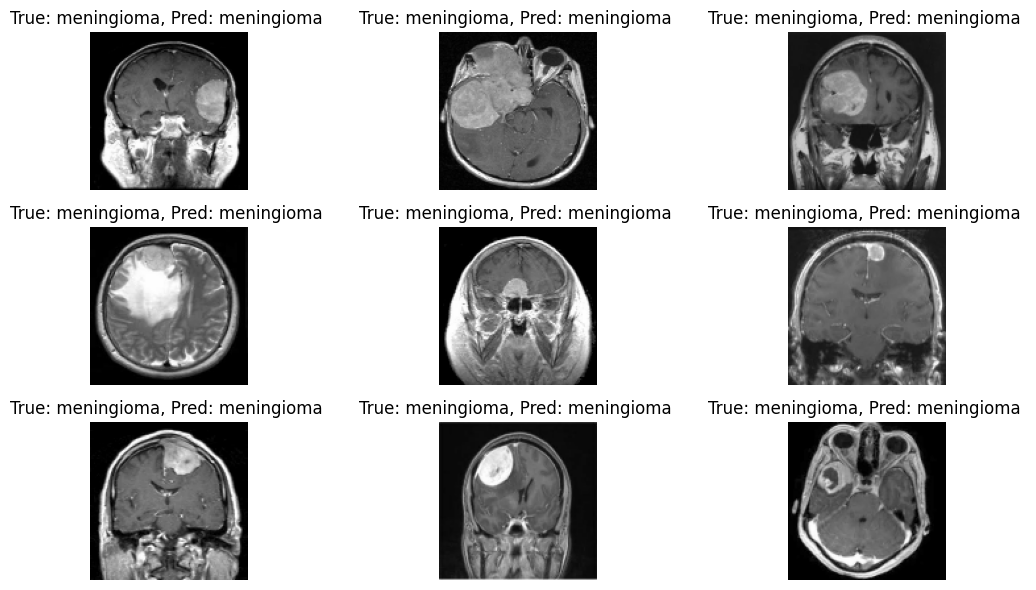

In [118]:
# Step 3: Visualize the misclassified images
plt.figure(figsize=(12, 6))
for i, idx in enumerate(meningioma_correct_indices[:9]):  # Show up to 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[idx].astype("uint8"))
    plt.title(f"True: meningioma, Pred: meningioma ")
    plt.axis("off")

plt.tight_layout()
plt.show()

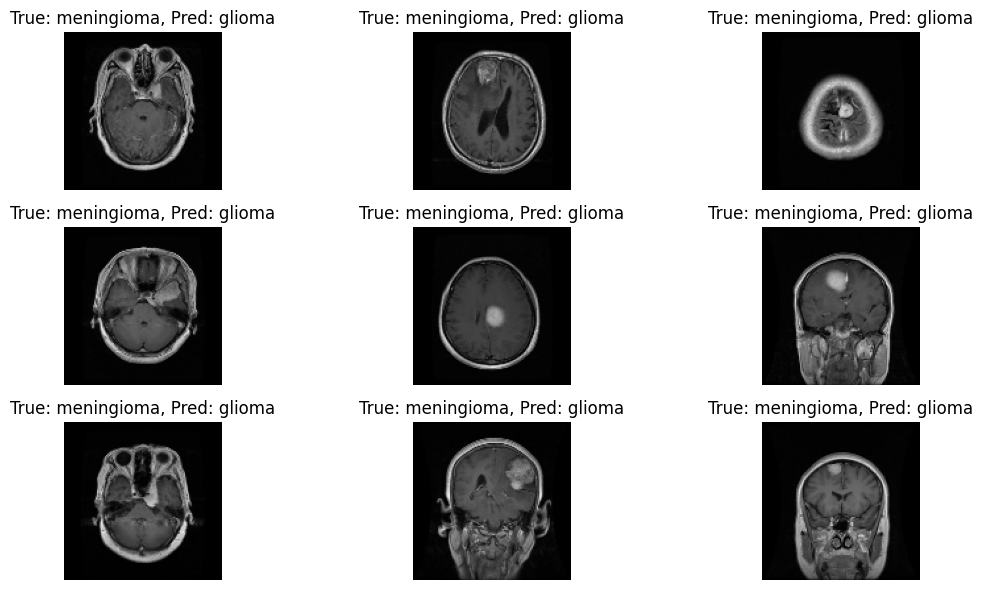

In [119]:
# Step 3: Visualize the misclassified images
plt.figure(figsize=(12, 6))
for i, idx in enumerate(meningioma_misclassified_glioma_indices[:9]):  # Show up to 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[idx].astype("uint8"))
    plt.title(f"True: meningioma, Pred: glioma")
    plt.axis("off")

plt.tight_layout()
plt.show()

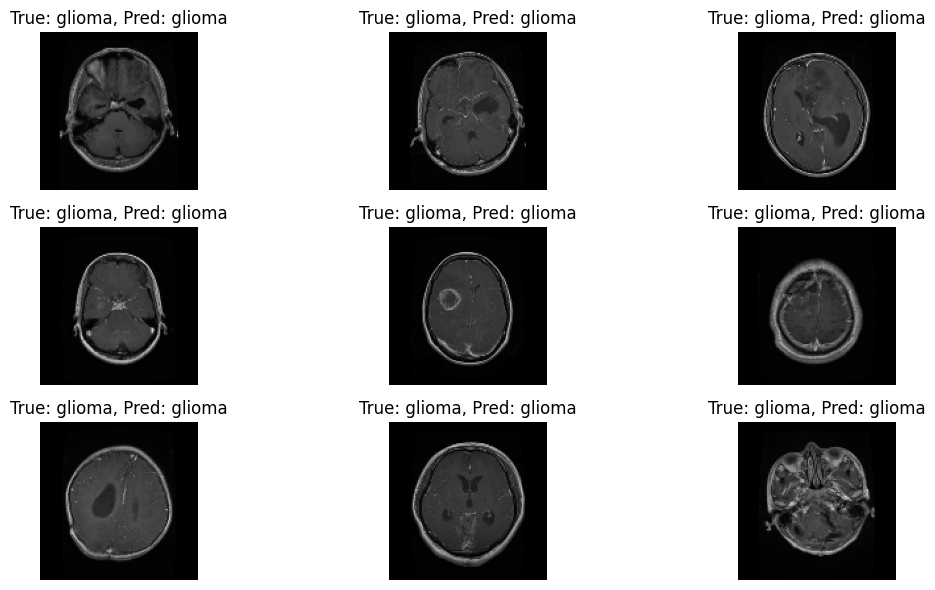

In [124]:
# Step 3: Visualize the misclassified images
plt.figure(figsize=(12, 6))
for i, idx in enumerate(glioma_correct_indices[:9]):  # Show up to 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[idx].astype("uint8"))
    plt.title(f"True: glioma, Pred: glioma")
    plt.axis("off")

plt.tight_layout()
plt.show()

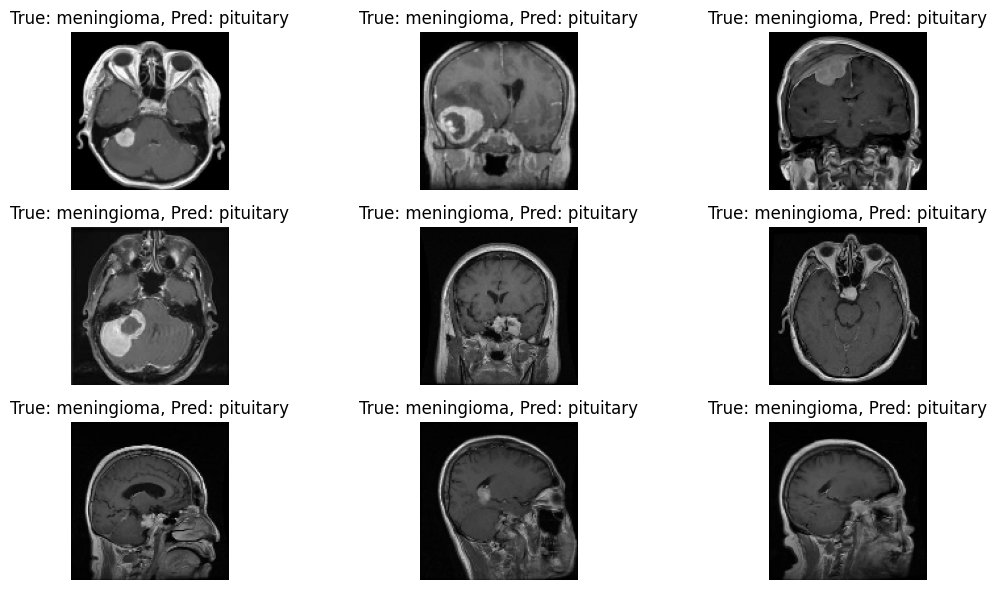

In [122]:
# Step 3: Visualize the misclassified images
plt.figure(figsize=(12, 6))
for i, idx in enumerate(meningioma_misclassified_pituitary_indices[:9]):  # Show up to 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[idx].astype("uint8"))
    plt.title(f"True: meningioma, Pred: pituitary")
    plt.axis("off")

plt.tight_layout()
plt.show()

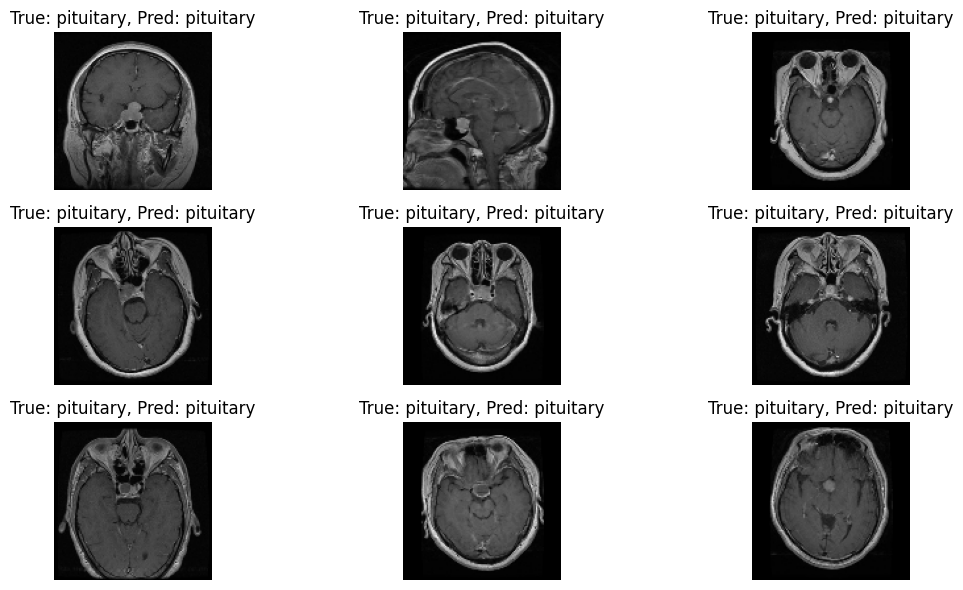

In [123]:
# Step 3: Visualize the misclassified images
plt.figure(figsize=(12, 6))
for i, idx in enumerate(pituitary_correct_indices[:9]):  # Show up to 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[idx].astype("uint8"))
    plt.title(f"True: pituitary, Pred: pituitary")
    plt.axis("off")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━

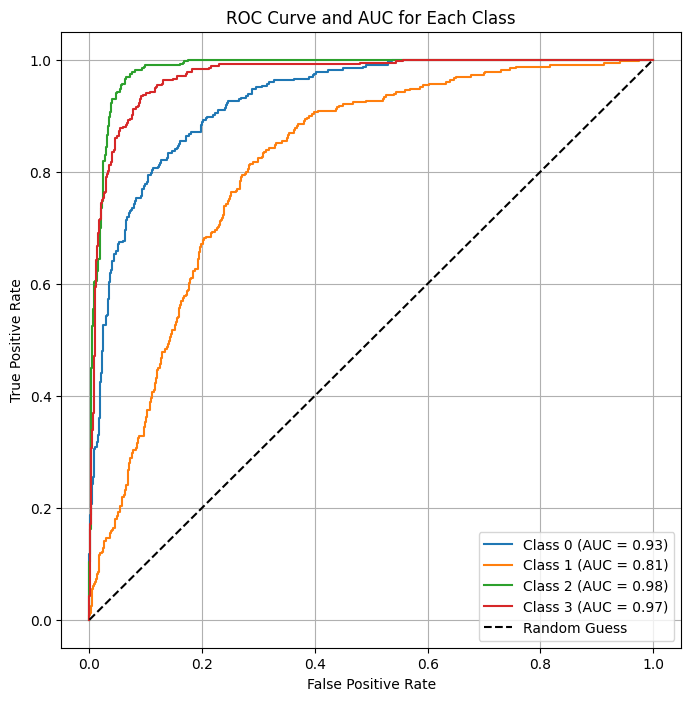

In [125]:
from sklearn.metrics import roc_curve, auc

# Step 1: Get true labels and predicted probabilities
true_labels = []
predicted_probs = []

for img_batch, label_batch in test_ds:
    true_labels.extend(label_batch.numpy())
    predicted_probs.extend(model.predict(img_batch))

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# Step 2: Compute ROC and AUC for each class
n_classes = true_labels.shape[1]  # Number of classes
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 3: Plot the ROC curves for each class
plt.figure(figsize=(8, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Add diagonal line
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

# Plot settings
plt.title("ROC Curve and AUC for Each Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()
